In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
plt.style.use('seaborn-v0_8-deep')

### Choose which events to work with

In [22]:

# Big event to work with (M4.9):
# 2024-01-07 05:50:08 (UTC)
big_event = ['/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_50Hz/decimator2_2024-01-07_05.50.04_UTC.h5',
             '/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_50Hz/decimator2_2024-01-07_05.51.04_UTC.h5']
big_start_time = 17

# Small event to work with (M3.0)
# 2024-01-06 23:33:48 (UTC)
small_event = ['/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_50Hz/decimator2_2024-01-06_23.33.04_UTC.h5',
         '/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_50Hz/decimator2_2024-01-06_23.34.04_UTC.h5']
small_start_time = 57

noise_window = ['/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_50Hz/decimator2_2024-01-07_05.49.04_UTC.h5']

In [3]:

# # Big event to work with (M4.9):
# # 2024-09-01 13:20:21 (UTC)
# big_event = ['/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_50Hz/decimator2_2024-09-01_13.19.37_UTC.h5',
#          '/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_50Hz/decimator2_2024-09-01_13.20.37_UTC.h5']
# big_start_time = 55

# # Small event to work with (M3.0)
# TBD

In [4]:
# Two cool events:

# files = ['/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_50Hz/decimator2_2024-06-01_12.40.13_UTC.h5']

In [23]:
def get_data(files):
    for i,file in enumerate(files):
        data = h5py.File(file, "r", locking=False)
        attrs=dict(data['Acquisition'].attrs)
        thisdas = np.array(data['Acquisition/Raw[0]/RawData'])
        thistime = np.array(data['Acquisition/Raw[0]/RawDataTime'])
        if i==0:
            das = thisdas
            time = thistime
        else:
            das = np.concatenate((das,thisdas),axis=0)
            time = np.concatenate((time,thistime),axis=0)
        data.close()
    dt = 1/attrs['MaximumFrequency']/2
    dx = attrs['SpatialSamplingInterval']
    nt,nx = das.shape

    x = np.linspace(0,nx*dx,nx)
    t = np.linspace(0,nt*dt,nt)
    return das, time, x, t, dt, dx

das_big, time_big, x, t, dt, dx = get_data(big_event)
das_small, time_small, x, t, dt, dx = get_data(small_event)
das_noise, time_noise, x, t, dt, dx = get_data(noise_window)

### Plot the filtered data to determine the appropriate time window for the analysis
These times are actually referenced above, where the file paths are given. So the notebook doesn't exactly flow in a logical order...

In [6]:

b,a = butter(2,1,'high',fs=1/dt)
data_hf_all_big = filtfilt(b,a,das_big,axis=0)
data_hf_all_small = filtfilt(b,a,das_small,axis=0)

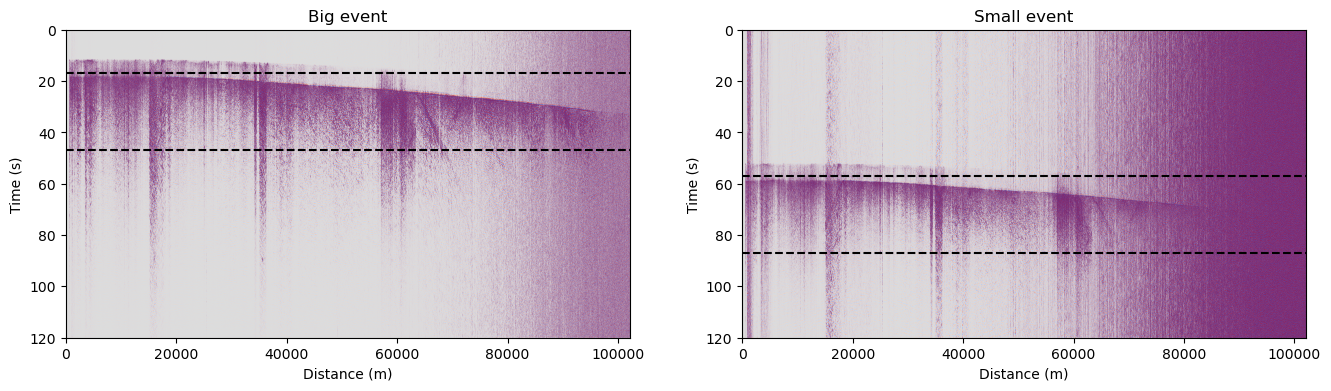

In [7]:
tmax = 30

vm = 10
plt.subplots(1,2,figsize=(16,4))
plt.subplot(1,2,1)
c=plt.imshow(data_hf_all_big,aspect='auto',cmap='coolwarm',
             vmin=-vm,vmax=vm,extent=[x[0],x[-1],t[-1],0])
plt.plot([x[0],x[-1]],[big_start_time,big_start_time],'k--')
plt.plot([x[0],x[-1]],[big_start_time+tmax,big_start_time+tmax],'k--')
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.title('Big event')

vm = 1
plt.subplot(1,2,2)
c=plt.imshow(data_hf_all_small,aspect='auto',cmap='coolwarm',
             vmin=-vm,vmax=vm,extent=[x[0],x[-1],t[-1],0])
plt.plot([x[0],x[-1]],[small_start_time,small_start_time],'k--')
plt.plot([x[0],x[-1]],[small_start_time+tmax,small_start_time+tmax],'k--')
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.title('Small event')
# plt.ylim(70,20)
plt.show()

### Window the data

In [24]:
window_len = int(tmax/dt)

t0_small = int(small_start_time/dt)
sl_small = slice(t0_small,t0_small + window_len)
data_window_small = das_small[ sl_small , : ]

t0_big = int(big_start_time/dt)
sl_big = slice(t0_big,t0_big + window_len)
data_window_big = das_big[ sl_big , : ]

t0_noise = 0
sl_noise = slice(t0_noise,t0_noise + window_len)
data_window_noise = das_noise[ sl_noise , : ]

t_windowed = t[ t<tmax ]

b,a = butter(2,1,'high',fs=1/dt)
data_hf_big = filtfilt(b,a,data_window_big,axis=0)
data_hf_small = filtfilt(b,a,data_window_small,axis=0)
data_hf_noise = filtfilt(b,a,data_window_noise,axis=0)
print (data_hf_big.shape)
print (data_hf_small.shape)
print (data_hf_noise.shape)

(1500, 10664)
(1500, 10664)
(1500, 10664)


### Compute normal moveout offset (NMO)
Since the big and small events are similar, this should be the same for both.

In [45]:
x0 = 10e3
xoffsets = x - x0
yoffsets = 40e3
zoffsets = 40e3
v = 3.75e3
moveout_times = np.sqrt((xoffsets / v)**2 + (yoffsets / v)**2 + (zoffsets / v)**2)
moveout_times = moveout_times - np.min(moveout_times)
moveout_times

array([ 0.23388904,  0.23344489,  0.23300115, ..., 13.72654417,
       13.72871898, 13.73089386])

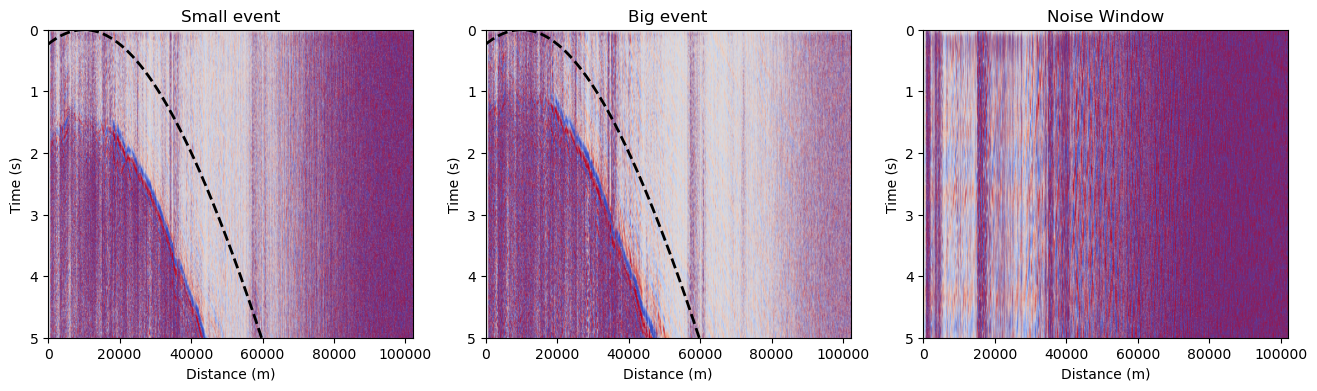

In [46]:
vm = 1

plt.subplots(1,3,figsize=(16,4))
plt.subplot(1,3,1)
c=plt.imshow(data_hf_small,aspect='auto',cmap='coolwarm',
             vmin=-vm,vmax=vm,extent=[x[0],x[-1],tmax,0])
# plt.colorbar(c)
plt.plot(x, moveout_times, 'k--', linewidth=2, label='Hyperbolic moveout')
plt.xlabel('Distance (m)')
plt.ylim([5,0])
plt.ylabel('Time (s)')
plt.title('Small event')


vm = 10
plt.subplot(1,3,2)
c=plt.imshow(data_hf_big,aspect='auto',cmap='coolwarm',
             vmin=-vm,vmax=vm,extent=[x[0],x[-1],tmax,0])
# plt.colorbar(c)
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.title('Big event')
plt.plot(x, moveout_times, 'k--', linewidth=2, label='Hyperbolic moveout')
plt.ylim([5,0])

plt.subplot(1,3,3)
vm = 0.1
c=plt.imshow(data_hf_noise,aspect='auto',cmap='coolwarm',
             vmin=-vm,vmax=vm,extent=[x[0],x[-1],tmax,0])
# plt.colorbar(c)
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.title('Noise Window')
plt.ylim([5,0])
plt.show()

In [47]:
from scipy.interpolate import interp1d
import numpy as np

def apply_moveout_correction(data, t, moveout_times):
    """
    Apply moveout correction to seismic data using precomputed moveout_times.

    Parameters:
    - data: ndarray of shape (nt, nx)
    - t: 1D array of time samples (length nt)
    - moveout_times: 1D array of moveout delays for each trace (length nx)

    Returns:
    - data_corrected: ndarray of shape (nt, nx), moveout-corrected data
    """
    nt, nx = data.shape
    t = np.asarray(t)
    moveout_times = np.asarray(moveout_times)

    if len(t) != nt:
        raise ValueError(f"Length of t ({len(t)}) must match number of rows in data ({nt}).")
    if len(moveout_times) != nx:
        raise ValueError(f"Length of moveout_times ({len(moveout_times)}) must match number of columns in data ({nx}).")

    data_corrected = np.zeros_like(data)

    for ix in range(nx):
        t_shift = moveout_times[ix]
        f = interp1d(t, data[:, ix], bounds_error=False, fill_value=0.0)
        t_corrected = t + t_shift
        data_corrected[:, ix] = f(t_corrected)

    return data_corrected


# Apply NMO correction, and then window the data to the first final_window_len seconds
final_window_len = 20
t_nmo = t_windowed[ (t_windowed<final_window_len) ]
data_nmo_small = apply_moveout_correction(data_hf_small, t_windowed, moveout_times)
data_nmo_small = data_nmo_small[ (t_windowed<final_window_len) , : ]

data_nmo_big = apply_moveout_correction(data_hf_big, t_windowed, moveout_times)
data_nmo_big = data_nmo_big[ (t_windowed<final_window_len) , : ]

data_nmo_noise = apply_moveout_correction(data_hf_noise, t_windowed, moveout_times)
data_nmo_noise = data_nmo_noise[ (t_windowed<final_window_len) , : ]

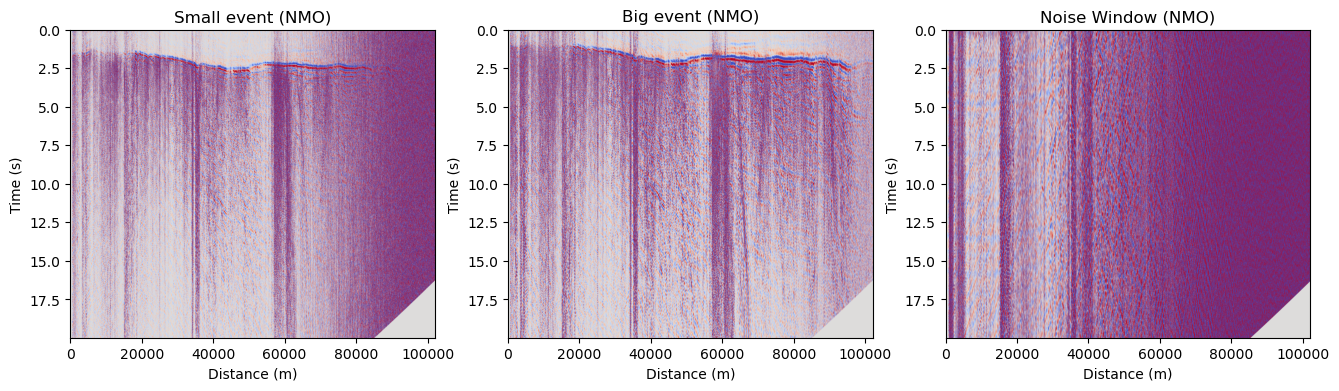

In [48]:
vm = 2

plt.subplots(1,3,figsize=(16,4))
plt.subplot(1,3,1)
c=plt.imshow(data_nmo_small,aspect='auto',cmap='coolwarm',
             vmin=-vm,vmax=vm,extent=[x[0],x[-1],t_nmo[-1],0])
# plt.colorbar(c)
plt.xlabel('Distance (m)')
# plt.ylim([15,0])
plt.ylabel('Time (s)')
plt.title('Small event (NMO)')


vm = 20
plt.subplot(1,3,2)
c=plt.imshow(data_nmo_big,aspect='auto',cmap='coolwarm',
             vmin=-vm,vmax=vm,extent=[x[0],x[-1],t_nmo[-1],0])
# plt.colorbar(c)
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.title('Big event (NMO)')
# plt.ylim([15,0])

plt.subplot(1,3,3)
vm = 0.1
c=plt.imshow(data_nmo_noise,aspect='auto',cmap='coolwarm',
             vmin=-vm,vmax=vm,extent=[x[0],x[-1],t_nmo[-1],0])
# plt.colorbar(c)
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.title('Noise Window (NMO)')
# plt.ylim([15,0])
plt.show()

### Calculate the spectral ratio

In [13]:
from scipy.fft import fft, fftfreq, fftshift
ft_small = fftshift(fft(data_nmo_small,axis=0),axes=0)
ft_big = fftshift(fft(data_nmo_big,axis=0),axes=0)
ft_noise = fftshift(fft(data_nmo_noise,axis=0),axes=0)

f = fftshift(fftfreq(data_nmo_big.shape[0],d=dt),axes=0)

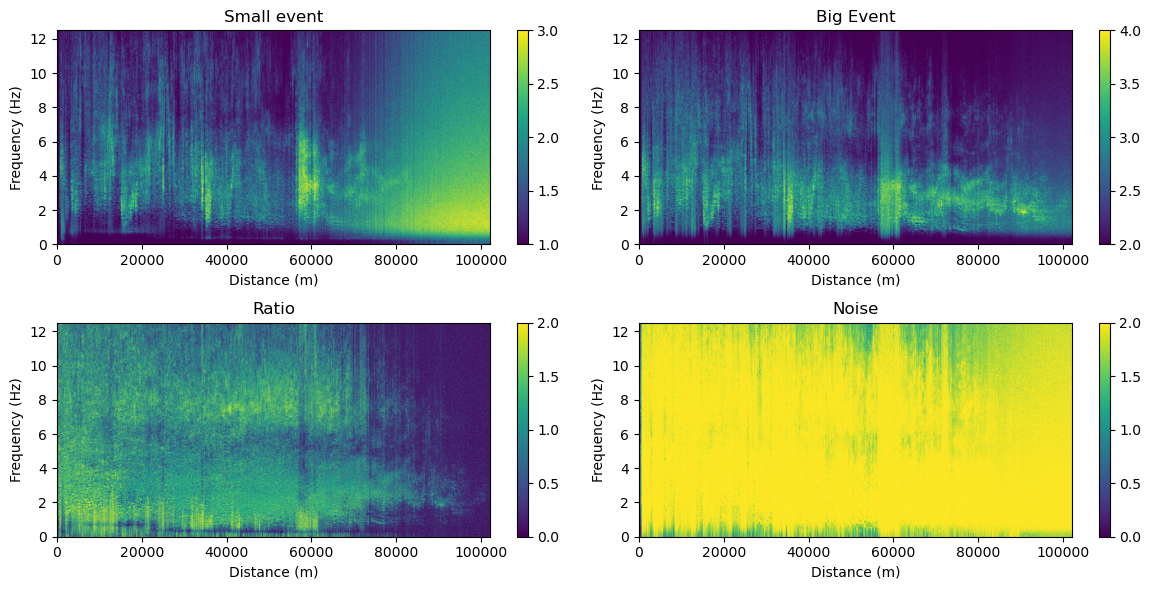

In [14]:
fmax = 12.5

vmin = 1
vmax = 3
plt.subplots(2,2,figsize=(12,6))
plt.subplot(2,2,1)

c=plt.imshow(np.log10(np.abs(ft_small)),aspect='auto',cmap='viridis',
             vmin=vmin,vmax=vmax,extent=[x[0],x[-1],f[0],f[-1]])
plt.colorbar(c)
plt.xlabel('Distance (m)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0,fmax])
plt.title('Small event')

vmin = 2
vmax = 4
plt.subplot(2,2,2)
c=plt.imshow(np.log10(np.abs(ft_big)),aspect='auto',cmap='viridis',
             vmin=vmin,vmax=vmax,extent=[x[0],x[-1],f[0],f[-1]])
plt.colorbar(c)
plt.xlabel('Distance (m)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0,fmax])
plt.title('Big Event')

vmin = 0
vmax = 2
plt.subplot(2,2,3)
c=plt.imshow(np.log10(np.abs(ft_big/ft_small)),aspect='auto',cmap='viridis',
             vmin=vmin,vmax=vmax,extent=[x[0],x[-1],f[0],f[-1]])
plt.colorbar(c)
plt.xlabel('Distance (m)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0,fmax])
plt.title('Ratio')

vmin = 0
vmax = 2
plt.subplot(2,2,4)
c=plt.imshow(np.log10(np.abs(ft_noise)),aspect='auto',cmap='viridis',
             vmin=vmin,vmax=vmax,extent=[x[0],x[-1],f[0],f[-1]])
plt.colorbar(c)
plt.xlabel('Distance (m)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0,fmax])
plt.title('Noise')

plt.tight_layout()
plt.show()

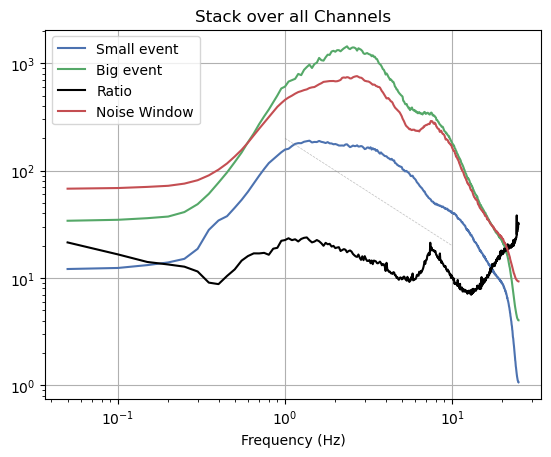

In [15]:
fig,ax=plt.subplots()
plt.title('Stack over all Channels')
plt.loglog(f[f>0], np.mean((np.abs(ft_small[f>0])),axis=1),label='Small event')
plt.loglog(f[f>0], np.mean((np.abs(ft_big[f>0])),axis=1),label='Big event')
plt.loglog(f[f>0], np.mean((np.abs(ft_big[f>0]/ft_small[f>0])),axis=1),'-k',label='Ratio')
plt.loglog(f[f>0], np.mean((np.abs(ft_noise[f>0])),axis=1),label='Noise Window')
plt.plot([1,10],[200,20],'--',linewidth=0.5,c='gray',alpha=0.5)
# plt.ylim([0.1,10])
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

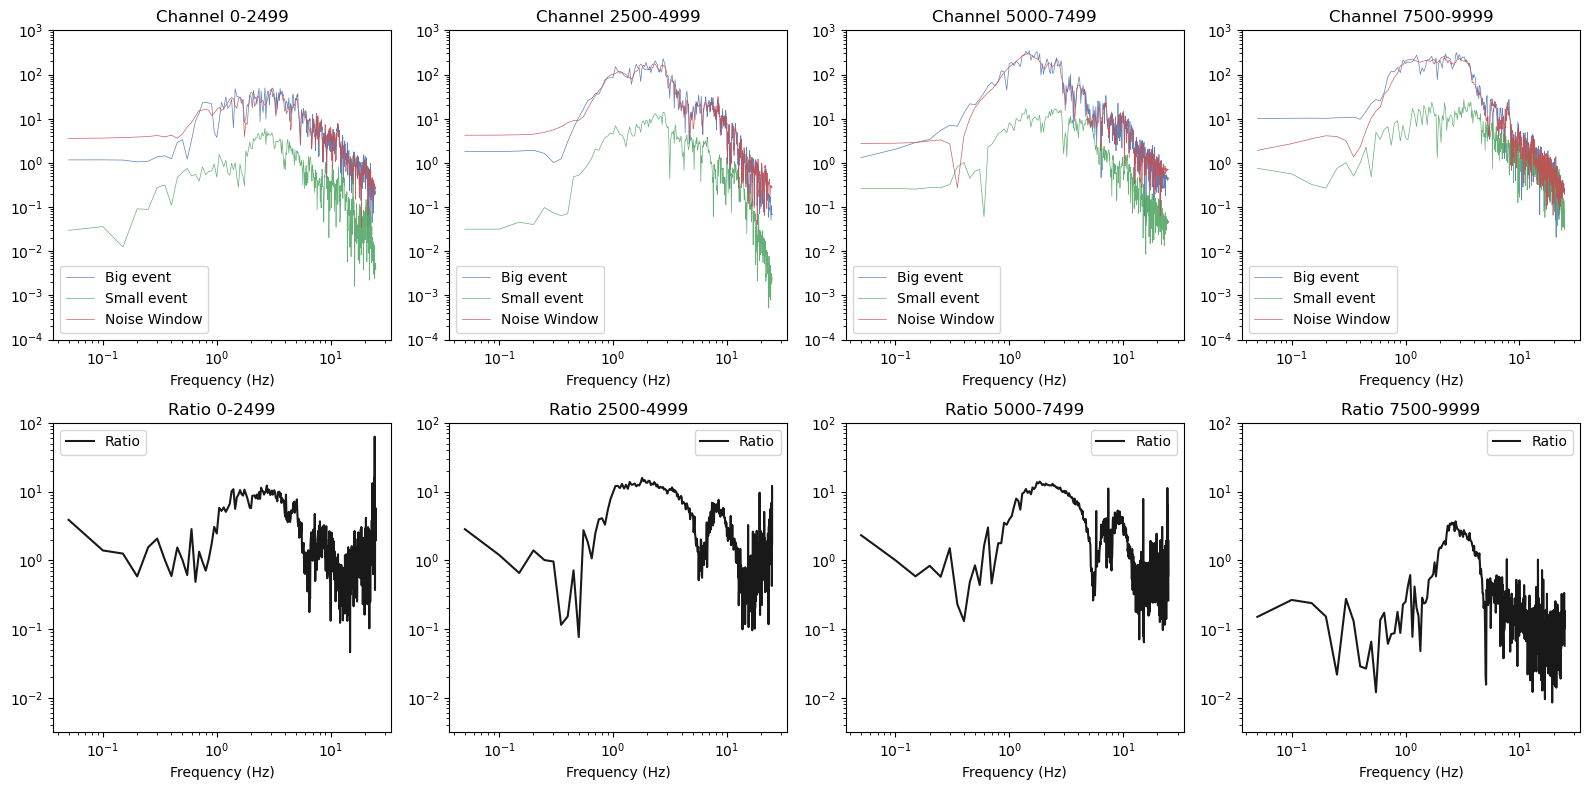

In [16]:
dx = 2499
fig, axs = plt.subplots(2, 4, figsize=(16, 8), gridspec_kw={'height_ratios': [1, 1]})

for i, ind in zip(range(4), [0, 2500, 5000, 7500]):
    # First row: Big event, Small event, Noise Window
    axs[0, i].loglog(f[f > 0], np.abs(np.mean(ft_big[f > 0, ind:ind + dx], axis=1)), linewidth=0.5, label='Big event', alpha=0.9)
    axs[0, i].loglog(f[f > 0], np.abs(np.mean(ft_small[f > 0, ind:ind + dx], axis=1)), linewidth=0.5, label='Small event', alpha=0.9)
    axs[0, i].loglog(f[f > 0], np.abs(np.mean(ft_noise[f > 0, ind:ind + dx], axis=1)), linewidth=0.5, label='Noise Window', alpha=0.9)
    axs[0, i].set_ylim([1e-4, 1e3])
    axs[0, i].set_xlabel('Frequency (Hz)')
    axs[0, i].legend()
    axs[0, i].set_title('Channel %d-%d' % (ind, ind + dx))

    # Second row: Ratio
    axs[1, i].loglog(f[f > 0], np.abs(np.mean(ft_big[f > 0, ind:ind + dx] / ft_small[f > 0, ind:ind + dx], axis=1)), '-k', label='Ratio', alpha=0.9)
    axs[1, i].set_ylim([10**(-2.5), 1e2])
    axs[1, i].set_xlabel('Frequency (Hz)')
    axs[1, i].legend()
    axs[1, i].set_title('Ratio %d-%d' % (ind, ind + dx))

plt.tight_layout()
plt.show()

### Attempt to calculate the inverse transform to find time-domain source time functions

In [17]:
from scipy.fft import ifft, ifftshift

ft_ratio = ft_big/ ft_small
ratio = ifft(ifftshift(ft_ratio,axes=0),axis=0)
b,a = butter(2,[1,10],'bandpass',fs=1/dt)
ratio_smooth = filtfilt(b,a,np.mean(ratio,axis=1))
ratio_avg=np.mean(ratio,axis=1)


/home/bpl7/.conda/envs/2025-March/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/bpl7/.conda/envs/2025-March/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


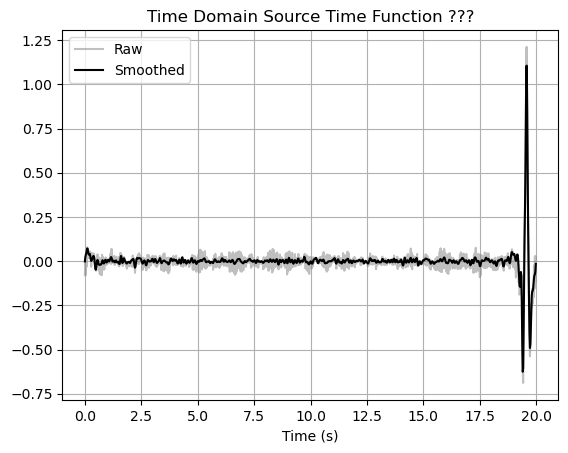

In [18]:
plt.subplots()
plt.plot(t_nmo,ratio_avg,color='gray',alpha=0.5,label='Raw')
plt.plot(t_nmo,ratio_smooth,'-k',label='Smoothed')
plt.title('Time Domain Source Time Function ???')
plt.legend()
plt.grid()
plt.xlabel('Time (s)')
plt.show()

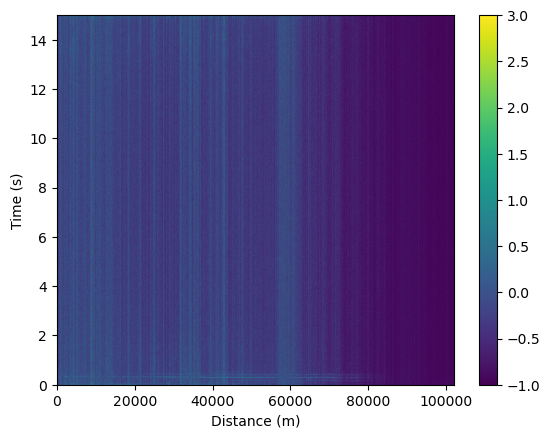

In [19]:
plt.subplots()
c=plt.imshow(np.log10(np.abs(ratio)),aspect='auto',cmap='viridis',
             extent=[x[0],x[-1],0,15],vmin=-1,vmax=3)
plt.colorbar(c)
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.show()